In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt

from mujoco_py import MjSim, load_model_from_path, functions as mjf
from shared_utils import models_folder_path

In [5]:
model_path = os.path.join(models_folder_path(), "debug", "falling_cube.xml")
assert os.path.isfile(model_path)

model = load_model_from_path(model_path)


In [13]:
pend_joint_id = model.joint_name2id('pend_axis')
pend_act_id = model.actuator_name2id('pend_ctrl')
# falling_box_id = model.joint_name2id('free_joint')

In [28]:
n_steps = 1000
angular_pos = np.zeros(n_steps)
angular_vel = np.zeros(n_steps)
qfrc_bias_arr = np.zeros(n_steps)
qacc_arr = np.zeros(n_steps)
qfrc_inv_arr = np.zeros(n_steps)
rne_arr = np.zeros(n_steps)
time_array = np.arange(n_steps)*model.opt.timestep

sim = MjSim(model)
sim.forward()

sim.data.ctrl[pend_act_id] = 0.

for step_idx in range(n_steps):
    angular_pos[step_idx] = sim.data.get_joint_qpos('pend_axis')
    angular_vel[step_idx] = sim.data.get_joint_qvel('pend_axis')
    qfrc_bias_arr[step_idx] = sim.data.qfrc_bias[pend_joint_id]
    qacc_arr[step_idx] = sim.data.qacc[pend_joint_id]

    mjf.mj_rnePostConstraint(model, sim.data)
    

    # fill qfrc_inverse
    mjf.mj_inverse(model, sim.data)
    qfrc_inv_arr[step_idx] = sim.data.qfrc_inverse[pend_joint_id]

    sim.step()

# manual differentiation of speed
euler_acc = np.zeros(n_steps)
euler_acc[1:] = (angular_vel[1:] - angular_vel[:-1]) / model.opt.timestep
euler_acc[0] = euler_acc[1]

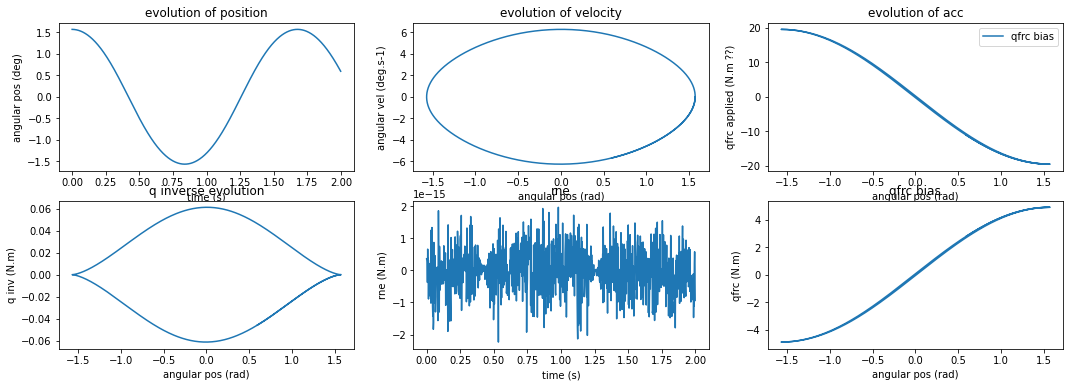

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(18, 6))

axes[0,0].plot(time_array, angular_pos)
axes[0,0].set_xlabel('time (s)')
axes[0,0].set_ylabel('angular pos (deg)')
axes[0,0].set_title('evolution of position')

axes[0,1].plot(angular_pos, angular_vel)
axes[0,1].set_xlabel('angular pos (rad)')
axes[0,1].set_ylabel('angular vel (deg.s-1)')
axes[0,1].set_title('evolution of velocity')

axes[0,2].plot(angular_pos, qacc_arr, label="qfrc bias")
# axes[0,2].plot(angular_pos, euler_acc, label="acc approx")
axes[0,2].legend()
axes[0,2].set_xlabel('angular pos (rad)')
axes[0,2].set_ylabel('qfrc applied (N.m ??)')
axes[0,2].set_title('evolution of acc')

axes[1,0].plot(angular_pos, qfrc_inv_arr, label="qfrc inv")
axes[1,0].set_xlabel('angular pos (rad)')
axes[1,0].set_ylabel('q inv (N.m)')
axes[1,0].set_title('q inverse evolution')

axes[1,1].plot(time_array, rne_arr)
axes[1,1].set_xlabel('time (s)')
axes[1,1].set_ylabel('rne (N.m)')
axes[1,1].set_title('rne')

axes[1,2].plot(angular_pos, qfrc_bias_arr)
axes[1,2].set_xlabel('angular pos (rad)')
axes[1,2].set_ylabel('qfrc (N.m)')
axes[1,2].set_title('qfrc bias')

plt.show()

In [80]:
for _ in range(10):
    sim.step()

In [19]:
sim.data.qfrc_inverse

array([-0.04651126])

In [18]:
mjf.mj_inverse(model, sim.data)

In [79]:
sim.data.qpos

array([ 0.        ,  0.        , -0.050031  ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.47116592])

In [24]:
res = np.zeros(model.nv)
mjf.mj_rne(model, sim.data, 1, res)

In [25]:
res

array([1.15012166e-15])

In [26]:
res = np.zeros(5)
mjf.mj_rne(model, sim.data, 1, res[:1])
res

array([1.15012166e-15, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [31]:
mjf.mj_rnePostConstraint(model, sim.data)

In [32]:
sim.data.cacc

array([[  0.        ,   0.        ,   0.        ,  -0.        ,
         -0.        ,   9.81      ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   9.81      ],
       [-10.94478492,   0.        ,   0.        ,   0.        ,
         -4.53357951,   6.74507976]])

In [34]:
body_id = model.body_name2id('pendulum')

In [35]:
sim.data.cacc[body_id]

array([-10.94478492,   0.        ,   0.        ,   0.        ,
        -4.53357951,   6.74507976])

In [36]:
sim.data.cinert[body_id]

array([ 1.00000000e-03,  1.00000000e-03,  1.00000000e-03,  0.00000000e+00,
        0.00000000e+00, -5.42101086e-20,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00])